In [1]:
%pip install --upgrade jupyter ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install sentence-transformers


Note: you may need to restart the kernel to use updated packages.


In [3]:

# 검증을 한번 하고 문서가 사용자의 질문과 관련이 있으면 genenrate를 하고 그렇지 않으면 rewrite를 통해서 사용자의 질문을 문맥에 맡게 수정한 다음에 문서를 다시 가져오는 절차를 짚어보도록 하겠다.

# 4개의 노드가 필요하다.
#   1. ritrieve
#   2. generate
#   3. rewrite
#   4. 문서 검증 노드
# ![image.png](attachment:image.png)

# 먼저 생성 해 두었던 chromaDB에 접근하도록 한다.
# 생성할 때는 from_documents 메소드를 사용 했었다. 이거는 chromaDB 가 존재 하지 않는 경우에 사용 하는 방법이다.
# 이미 생성한 chromaDB에 접근하기 위해서는 chroma 클래스를 바로 써야 한다.
# 벡터 생성할 때 쓴 코드를 그대로 가져온다.


from langchain_chroma import Chroma
# from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings


# KURE-v1 임베딩 설정
# ✅ LangChain에서 사용할 수 있는 임베딩 모델 설정
model_name = "nlpai-lab/KURE-v1"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}

embeddings_function = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# ✅ 기존 벡터 스토어를 불러오기
vector_store = Chroma(
    embedding_function=embeddings_function,  # ✅ HuggingFaceEmbeddings 사용
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"  # 저장된 벡터 스토어 경로
)

# ✅ Retrieval 객체 생성
retriever = vector_store.as_retriever(search_kwargs={"k": 3})


In [4]:
# 이제 state를 선언해서 우리가 원하는 agent를 만들어 보도록 하겠다.
# state는 기존의 코드와 똑같이 선언해 주면 된다.

# state를 만들고 시작해보자.

from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph # graph_builder까지 선언해 주도록 하겠다.

class AgentState(TypedDict):
    query: str # 질문
    context: List[Document] # 컨텍스트(답변할 때 참고할 문서들: langchain의 Document 타입) - 경로는 3.1의 from langchain_core.documents import Document
    answer: str # 답변


# graph_builder 선언.
graph_builder = StateGraph(AgentState)

# 이제 노드를 추가해 보도록 하겠다.



In [5]:
# retrieve 노드 추가

def retrieve(state: AgentState) -> AgentState:
    query = state['query'] # 사용자의 질문을 받아온 다음
    docs = retriever.invoke(query) # 기반으로 리트리버에 대해서 검색을 하고
    return {'context': docs} # state의 컨텍스트에 넣어준다.




In [6]:
# generate 노드 추가를 위해 llm과 프롬프트를 선언해 주도록 하겠다.

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [7]:
# 그런데 이번에는 generate에 쓸 prompt도 있어야 하고, question을 다시 쓸 때 사용자의  - 질문을 수정할 때 쓸 prompt도 있어야 한다. 그리고 문서의 관련성을 판단할 때 쓸 prompt도 있어야 한다.

#  - 따라서 prompt라고 변수를 하나만 정하면 중복이 될 수 있다.
#  - 공통으로 쓸 llm만 미리 선언하고 
#  - 프롬프트는 각각 선언해 주도록 하겠다.


# context 랑 query를 잘 받아와서, LLM을 invoke 하지 않고, 선언한 프롬프트를 활용해야한다.
# langchain의 LCEL 문법: 파이프 활용 해서 연결하는 것. 기반으로 체인을 만들어 준다.

from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.



In [8]:
# 이제 문서의 관련성을 측정할 노드를 만들어 보겠다.
# langsmith에서 rag-document-relevance라는 프롬프트를 제공해 준다.
# 사용자의 질문과 문서를 받아서 관련성을 측정해서 score를 반환해 준다.
# 이 score가 1이면 관련성이 높고, 0이면 관련성이 낮다.

# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull('langchain-ai/rag-document-relevance')

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context}) # 수정: context를 그대로 전달
    print(f'doc relevance response: {response}')
    
    # state를 설정하는 것이 아니라, 다음에 어디로 갈지 결정. 
    # 따라서 state를 return하면 안되고, score가  1이면 generate로 가고, 아니면 rewrite로 가도록 하겠다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

# def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
#     query = state['query']
#     context = state['context']
#     print(f'context == {context}')
#     doc_relevance_chain = doc_relevance_prompt | llm
#     response = doc_relevance_chain.invoke({'question': query, 'documents': context})
#     print(f'doc relevance response: {response}')
    
#     # 수정된 부분: 리스트의 첫 번째 요소에서 'args' 딕셔너리의 'Score' 값을 가져옴
#     score = response[0]['args']['Score']
    
    
#     if score == 1:
#         return 'generate'
#     return 'rewrite'

# def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
#     query = state['query']
#     context = state['context']
#     print(f'context == {context}')
#     doc_relevance_chain = doc_relevance_prompt | llm
#     response = doc_relevance_chain.invoke({'question': query, 'documents': context})
#     print(f'doc relevance response: {response}')

#     # 응답이 사전인지 확인하고 점수 추출
#     if isinstance(response, dict):
#         score = response.get('Score', 0)  # get을 사용하여 키가 없을 경우 기본값 0 할당
#     elif isinstance(response, int):  # 정수 응답 처리 추가
#         score = response
#     else:
#         score = 0  # 예외적인 응답 형식일 경우 기본값 0 할당

#     if score == 1:
#         return 'generate'

#     return 'rewrite'



In [9]:
# rewrite 노드 추가
# rewrite 는 검색을 용이하게 해 주기 위한것, 검색이 왜 안되었는지를 따져봐야 한다.
# 검색이 안되었던 이유는 사용자의 질문이 문서와 맞지 않았기 때문이다.
# 따라서 사용자의 질문을 문서와 맞게 수정해 주는 것이 필요하다.
# 이를 위해서 사용자의 질문을 수정해 주는 프롬프트를 제공해 준다.

# 검색이 잘 되도록 entity를 맞춤 설정해 주는 것이 필요하다.

# langchain_core.prompts 에서 PromptTemplate를 이용해 직접 작성한다다.
from langchain_core.prompts import PromptTemplate

# output type을 str로만 나오게 한다 : 왜냐하면 state를 보면 query가 str이기 때문이다.
from langchain_core.output_parsers import StrOutputParser 


dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query}) #response 가 BaseMessage 이므로 putput type을 str로 바꿔줘야 한다.
    return {'query': response}


In [10]:
# 필요한 노드들을 다 만들었다.
# 이제 노드들을 등록하고 엣지를 추가해 주도록 하겠다.

graph_builder.add_node('retrieve', retrieve)
# graph_builder.add_node('check_doc_relevance', check_doc_relevance)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [11]:
# 엣지 추가

from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_doc_relevance)
graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", END)

In [12]:
graph = graph_builder.compile() 

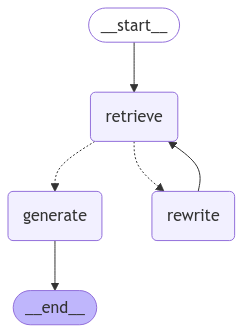

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 세금'}
print(f'initial_state == {initial_state}')
graph.invoke(initial_state)


initial_state == {'query': '연봉 5천만원 세금'}
context == [Document(id='10ef4b06-68a6-498f-959c-0f23f4e64610', metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속연수−10)\n법제처 | 31 | 국가법령정보센터'), Document(id='cfff6763-b959-4bc3-8dbe-38a218a8c1e8', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 

{'query': '연봉 5천만원 세금',
 'context': [Document(id='10ef4b06-68a6-498f-959c-0f23f4e64610', metadata={'source': './documents/income_tax.txt'}, page_content='1. 근속연수에 따라 정한 다음의 금액\n근속연수 | 공제액\n--- | ---\n5년 이하 | 100만원 공제소득\n5년 초과 10년 이하 | 500만원+200만원×(근속연수−5)\n10년 초과 20년 이하 | 1천500만원+250만원×(근속연수−10)\n법제처 | 31 | 국가법령정보센터'),
  Document(id='cfff6763-b959-4bc3-8dbe-38a218a8c1e8', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다